# Neural Networks with Pytorch

This notebook implements the utilities from `fullyconnected_neuralnetwork.py` in an easy example.
All in all, the basic use of Pytorch is showcased: dataset loading, model definition, model training, image inferece & visualization.
The notebook is divided in 4 sections:

1. Tensors: basic usage of the tensor structure is explained
2. Main Exemplary Application: `fullyconnected_neuralnetwork.py` is employed in an easy application
3. Custom datasets: how to prepare our images to generate a dataset
4. Additional features: manually defined networks, weight & bias access

## 1. Tensors

To have an idea of the concept of tensor structures, see `tensors.py`.

## 2. Main Exemplary Application
In this section, the generic utility script for neural network training and use `fullyconnected_neuralnetwork.py` is employed in an easy application in which the Fashion-MNIST dataset is used. What is done:
- Dataset is loaded and briefly checked
- Network is created
- Network is trained
- Network is saved and loaded again
- Network is inferred


In [25]:
# IMPORTS
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import helper_nn as hnn
import fullyconnected_neuralnetwork as fc_nn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# LOAD DATASET: example, Fashion-MNIST (28x28 pixels, 1 channel, 10 classes)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('../../../DL_PyTorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.FashionMNIST('../../../DL_PyTorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [ ]:
# CHECK DATSET
image, label = next(iter(trainloader))
print(trainset.classes)
hnn.imshow(image[0,:])

In [ ]:
# Have a clear idea of the image tensor shape
# [Batch size, channels, width, height]
image.shape

In [ ]:
# CREATE NETWORK
#input_size = 1*28*28 = 728
input_size = images.size()[1]*image.shape[2]*image.shape[3]
#output_size = 10
output_size = len(trainset.classes)
# Select desired number of hidden layers and their sizes
hidden_sizes = [512, 256, 128]
model = fc_nn.Network(input_size, output_size, hidden_sizes)
criterion = nn.NLLLoss() # Alternatives: nn.CrossEntropyLoss(), nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Alternatives: optim.SGD()

In [ ]:
# TRAIN
fc_nn.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

In [ ]:
# SAVE
filename = 'my_model_checkpoint.pth'
fc_nn.save_model(filename, model, input_size, output_size, hidden_sizes)

In [26]:
# LOAD
filename = 'my_model_checkpoint.pth'
model = fc_nn.load_model(filename)
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


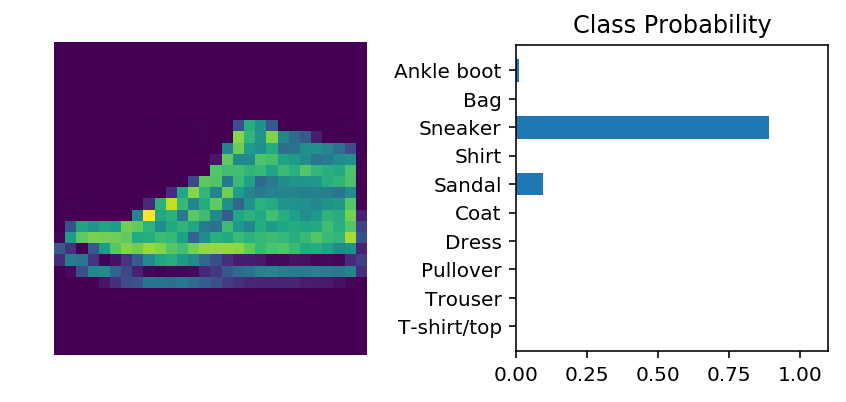

In [27]:
# INFER & VISUALIZE
model.eval()
images, labels = next(iter(testloader))
img = images[0]
#img = img.view(1, 28*28)
img = img.view(1, images.shape[2]*images.shape[3]) # Note: visualization for one channel
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)
hnn.view_classify(img.view(1, images.shape[2], images.shape[3]), ps, trainset.classes)

## 3. Custom Datasets

We might want to create our own dataset from images. This section shows how this works.

## 4. Additional

This section covers some additional features that can be useful:
- Manual network/model definition using `nn.Sequential()`
- Model layer bias & weight value access

In [22]:
# It is also possible to create amodel with nn.Sequential()
input_size = 1*28*28
hidden_sizes = [128, 64]
output_size = 10
from collections import OrderedDict
new_model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
print(new_model)

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [23]:
# We can read weights and biases of any layer
new_model.fc1.weight
new_model.fc1.bias

Parameter containing:
tensor([ 1.2624e-02, -8.4310e-03,  3.5508e-02, -3.0586e-02, -2.2860e-02,
        -3.2882e-02, -2.2698e-02, -2.6738e-02, -3.0339e-02,  2.9266e-02,
        -1.0604e-03,  2.7388e-02, -6.3977e-03,  3.4504e-02, -3.1466e-02,
        -3.4643e-02, -1.1987e-02,  2.1415e-02, -1.1425e-02,  6.0434e-03,
        -3.4202e-02, -3.3327e-02, -1.5326e-02, -4.4273e-03, -3.0222e-02,
         2.3461e-02, -2.7730e-02, -5.2601e-04,  1.4731e-02, -2.4910e-02,
         6.9448e-03, -3.3250e-02,  3.0766e-03,  1.1618e-02,  2.8924e-02,
         1.2337e-02, -6.7883e-03,  2.0544e-02, -3.0393e-02,  7.8684e-03,
         3.4199e-03, -1.4367e-02,  1.2098e-02,  1.3723e-02, -1.3008e-03,
        -2.5963e-02,  2.0062e-02, -1.4476e-02, -6.6730e-03, -2.0808e-02,
         3.4846e-02, -5.4765e-03,  3.3624e-02,  1.3993e-02,  1.1734e-02,
         1.6752e-02, -3.4175e-02,  2.0446e-02,  2.0644e-02, -1.0824e-02,
        -5.4581e-03, -1.7550e-02, -3.0841e-02, -2.4895e-02,  3.5111e-02,
        -3.7993e-03,  5.8977e

In [24]:
# We could set biases to all zeros
new_model.fc1.bias.data.fill_(0)
# We could sample from random normal (mean = 0) with standard dev = 0.01
new_model.fc1.weight.data.normal_(std=0.01)

tensor([[-6.3898e-03, -1.0709e-03,  9.4034e-03,  ..., -2.1064e-03,
          9.3746e-03,  1.4077e-03],
        [-4.3538e-03, -1.2296e-02,  1.0225e-02,  ...,  1.2385e-02,
         -4.8327e-03, -2.1808e-04],
        [ 7.7910e-03,  1.2422e-02,  6.7108e-03,  ..., -1.9733e-03,
          1.3427e-02,  4.1075e-03],
        ...,
        [ 3.8032e-03, -1.6118e-02,  1.1719e-02,  ...,  3.9777e-03,
         -1.6107e-02, -4.9561e-03],
        [ 2.9052e-02,  1.7483e-03,  1.0133e-03,  ...,  1.0154e-02,
          1.0634e-02,  7.5390e-03],
        [-1.1239e-02,  1.7839e-03,  9.9018e-06,  ...,  1.2776e-02,
         -7.9045e-03, -4.2083e-04]])